## Methods

### Exploratory Data Analysis and Visualization 

1. Load all the necessary libraries for data analysis along with `players.csv` from Canvas.
2. The dataset is already Tidy, so we will clean the dataset just to include predictors and response variables. Change the `subscribe` column to data type `fct` for knn-classification
3. Compute the summary statistics for the whole dataset.
4. Visualize the relationship between `Age`(years) and `played_hours`(hrs) with label `subscribe`

In [1]:
library(tidyverse)
library(tidymodels)
library(repr)
library(ggplot2)
options(repr.plot.width = 10, repr.plot.height = 6) #formats all scatterplots 

── Attaching core tidyverse packages ──────────────────────── tidyverse 2.0.0 ──
✔ dplyr     1.1.4     ✔ readr     2.1.5
✔ forcats   1.0.0     ✔ stringr   1.5.1
✔ ggplot2   3.5.1     ✔ tibble    3.2.1
✔ lubridate 1.9.3     ✔ tidyr     1.3.1
✔ purrr     1.0.2     
── Conflicts ────────────────────────────────────────── tidyverse_conflicts() ──
✖ dplyr::filter() masks stats::filter()
✖ dplyr::lag()    masks stats::lag()
ℹ Use the conflicted package (<http://conflicted.r-lib.org/>) to force all conflicts to become errors
── Attaching packages ────────────────────────────────────── tidymodels 1.1.1 ──

✔ broom        1.0.6     ✔ rsample      1.2.1
✔ dials        1.3.0     ✔ tune         1.1.2
✔ infer        1.0.7     ✔ workflows    1.1.4
✔ modeldata    1.4.0     ✔ workflowsets 1.0.1
✔ parsnip      1.2.1     ✔ yardstick    1.3.1
✔ recipes      1.1.0     

── Conflicts ───────────────────────────────────────── tidymodels_conflicts() ──
✖ scales::discard() masks purrr::discard()
✖ dplyr::filt

In [2]:
players_url <- "https://raw.githubusercontent.com/604Beast/Project-Planning-Stage/refs/heads/main/players.csv"
players <- read_csv(players_url)

Rows: 196 Columns: 7
── Column specification ────────────────────────────────────────────────────────
Delimiter: ","
chr (4): experience, hashedEmail, name, gender
dbl (2): played_hours, Age
lgl (1): subscribe

ℹ Use `spec()` to retrieve the full column specification for this data.
ℹ Specify the column types or set `show_col_types = FALSE` to quiet this message.


In [3]:
players_clean <- players |>
                select(subscribe,played_hours, Age) |> 
                mutate(subscribe = as.factor(subscribe)) 
head(players_clean)
                

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
TRUE,30.3,9
TRUE,3.8,17
FALSE,0.0,17
TRUE,0.7,21
TRUE,0.1,21
TRUE,0.0,17


Figure  1


In [4]:
players_summary <- players_clean|> 
            group_by(subscribe) |>
            summarize(mean_played_hours = round(mean(played_hours, na.rm = TRUE), 2 ), #rounded to 2 decimals
                     mean_Age = round(mean(Age, na.rm = TRUE), 2))

players_summary 

subscribe,mean_played_hours,mean_Age
<fct>,<dbl>,<dbl>
FALSE,0.50,23.75
TRUE,7.78,20.18


Figure 2

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


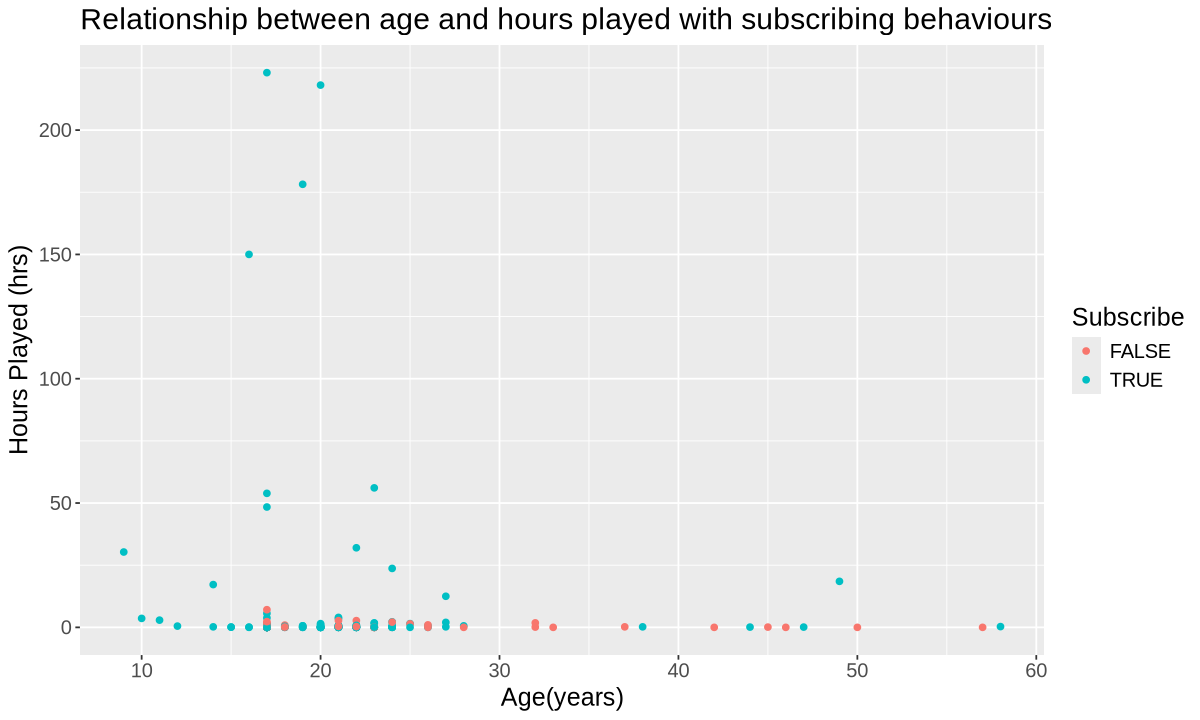

In [5]:

players_plot <- ggplot(players_clean, aes( x = Age, y = played_hours, color = subscribe))+
                    geom_point()+
                    ggtitle(" Relationship between age and hours played with subscribing behaviours") + 
                    labs( x = "Age(years)", y = "Hours Played (hrs)", color = "Subscribe")+ 
                    theme(text = element_text(size = 15)) +
                    theme(plot.title = element_text(hjust =0.5))
players_plot

Figure 3

Warning message:
“Removed 2 rows containing missing values or values outside the scale range
(`geom_point()`).”


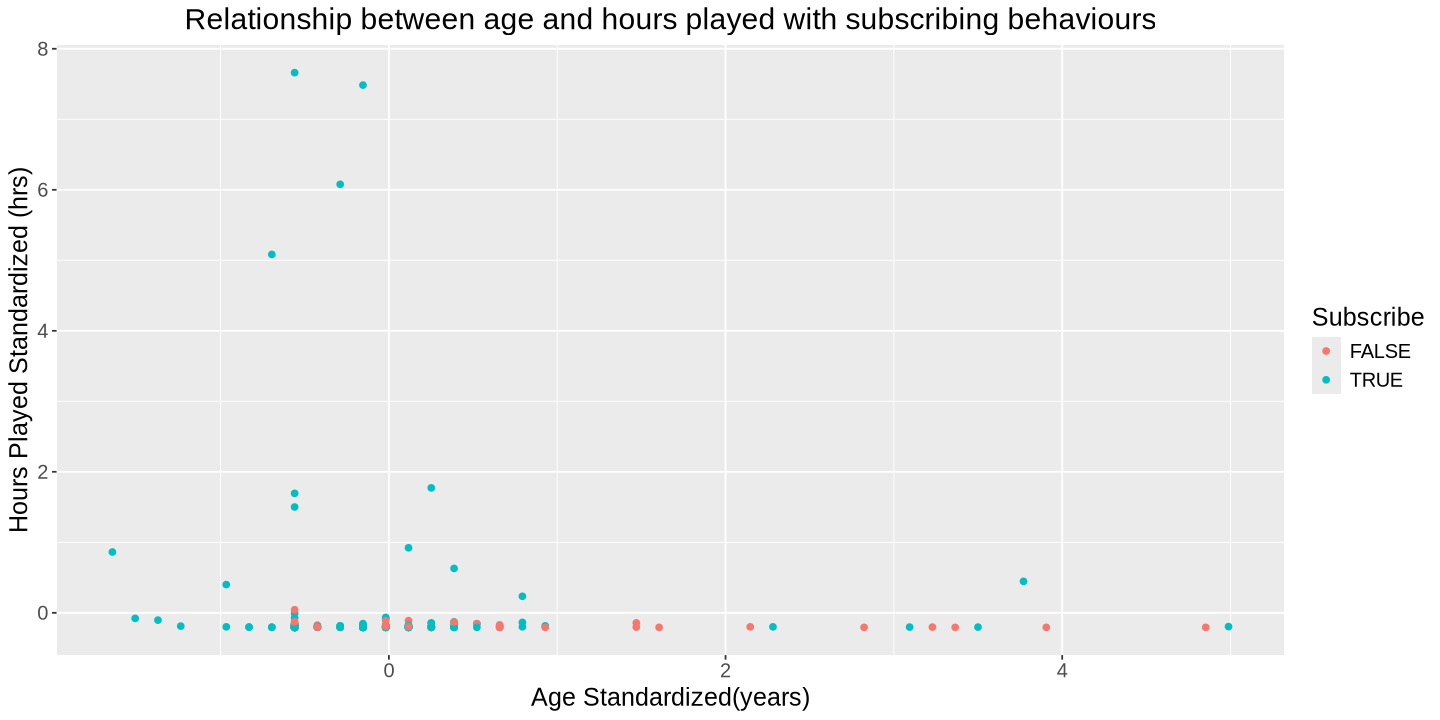

In [6]:
options(repr.plot.width = 12, repr.plot.height = 6)  
players_standardized <- subscribe_recipe <- recipe(subscribe ~ played_hours + Age, data = players_clean) |>
                    step_scale(all_predictors()) |>
                    step_center(all_predictors()) |>
                    prep() |>
                    bake(players_clean)

players_plot <-ggplot(players_standardized, aes( x = Age, y = played_hours, 
                                            color = subscribe))+
                    geom_point()+
                    ggtitle("Relationship between age and hours played with subscribing behaviours") + 
                    labs( x = "Age Standardized(years)", y = "Hours Played Standardized (hrs)", color = "Subscribe")+ 
                    theme(text = element_text(size = 15)) +
                    theme(plot.title = element_text(hjust =0.5))
players_plot

### Classifier preprocessing and finding the best $k$ value
1. Split the dataset into training and testing sets; the classifier will use the training set.
2. Summarize the training set

In [7]:
players_split <- initial_split(players_clean, prop = 0.70, strata = subscribe)  
players_training <- training(players_split)
players_testing <-testing(players_split)

head(players_training)
nrow(players_training)  
nrow(players_testing) 

subscribe,played_hours,Age
<fct>,<dbl>,<dbl>
FALSE,0.0,17
FALSE,0.0,21
FALSE,0.1,17
FALSE,0.1,18
FALSE,0.0,33
FALSE,0.0,24


[1] 136

[1] 60

In [18]:
set.seed(9999)
players_recipe <- recipe(subscribe ~ played_hours +Age, data = players_training)|> 
                step_scale(all_predictors()) |>
                step_center(all_predictors())

In [19]:
players_tune <- nearest_neighbor(weight_func = "rectangular", neighbors = tune()) |> 
            set_engine("kknn")|>
            set_mode("classification") 

In [20]:
players_vfold <- vfold_cv(players_training, v = 5, strata = subscribe)
k_vals <- tibble(neighbors = c(1:50))

In [21]:
players_results <-workflow() |>
                add_recipe(players_recipe)|>
                add_model(players_tune) |>
                tune_grid(resamples = players_vfold, grid = k_vals)|>
                collect_metrics()|>
                filter(.metric == "accuracy")|>
                select(neighbors, mean) |>
                arrange(desc(mean))

head(players_results)

→ A | error:   Assigned data `orig_rows` must be compatible with existing data.
               ✖ Existing data has 26 rows.
               ✖ Assigned data has 27 rows.
               ℹ Only vectors of size 1 are recycled.
               Caused by error in `vectbl_recycle_rhs_rows()`:
               ! Can't recycle input of size 27 to size 26.

There were issues with some computations   A: x1

There were issues with some computations   A: x1





neighbors,mean
<int>,<dbl>
18,0.7526455
17,0.7433862
19,0.7433862
21,0.7433862
23,0.7433862
16,0.7344577


Scale for x is already present.
Adding another scale for x, which will replace the existing scale.
Warning message:
“Removed 50 rows containing missing values or values outside the scale range
(`geom_point()`).”
Warning message:
“Removed 50 rows containing missing values or values outside the scale range
(`geom_line()`).”


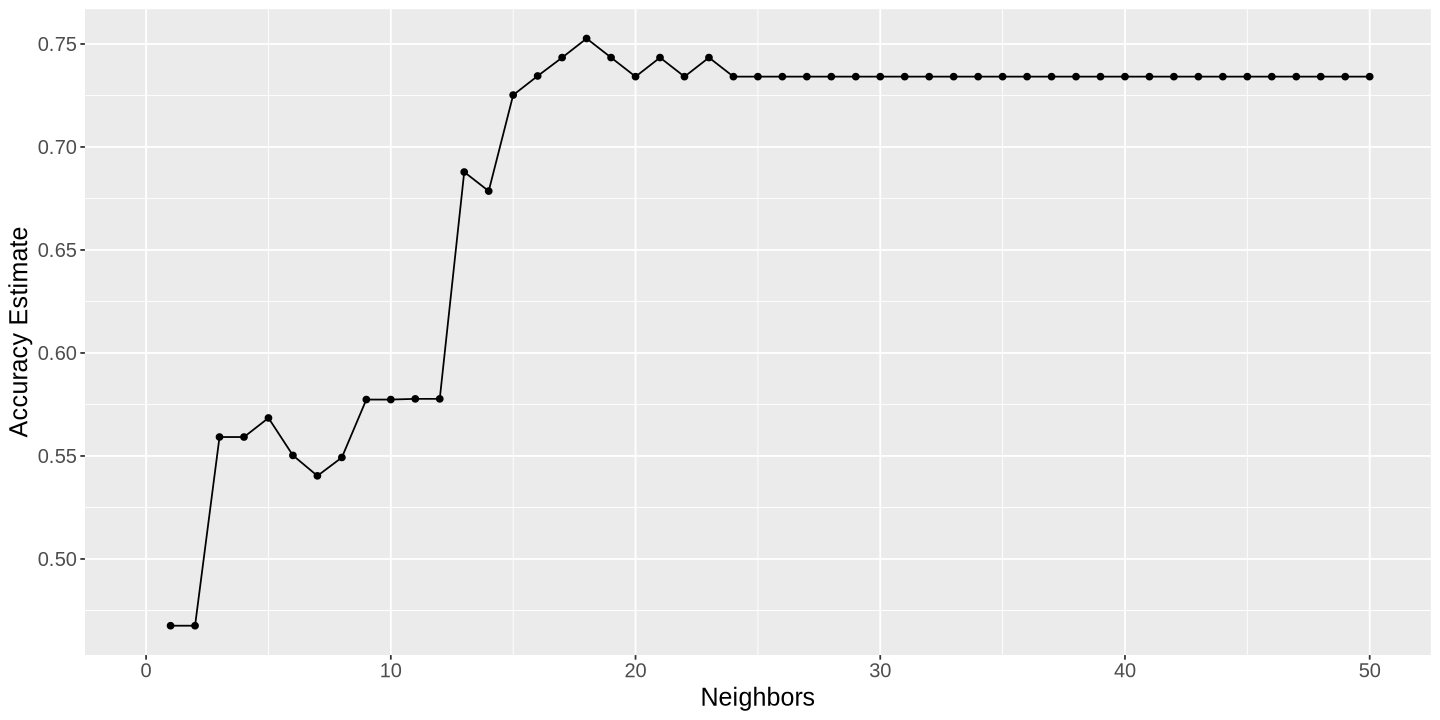

In [23]:
accuracy_vs_k <- ggplot(players_results, aes(x = neighbors, y = mean))+ 
                geom_point()+ 
                geom_line()+ 
                labs( x = "Neighbors", y = "Accuracy Estimate") + 
                scale_x_continuous(breaks = seq(0,50, by = 1)) + 
                theme(text = element_text(size = 15))+
                xlim(c(0,50))
accuracy_vs_k

In [24]:
players_best_spec <- nearest_neighbor(weight_func = "rectangular", neighbors = 18) |>
                set_engine("kknn") |>
                set_mode("classification")
players_fit <- workflow() |>
            add_recipe(players_recipe) |>
            add_model(players_best_spec) |>
            fit(data = players_training)


players_fit


                                       

══ Workflow [trained] ══════════════════════════════════════════════════════════
Preprocessor: Recipe
Model: nearest_neighbor()

── Preprocessor ────────────────────────────────────────────────────────────────
2 Recipe Steps

• step_scale()
• step_center()

── Model ───────────────────────────────────────────────────────────────────────

Call:
kknn::train.kknn(formula = ..y ~ ., data = data, ks = min_rows(18,     data, 5), kernel = ~"rectangular")

Type of response variable: nominal
Minimal misclassification: 0.2740741
Best kernel: rectangular
Best k: 18

In [11]:
set.seed(9999)
players_predictions <- predict(players_fit, players_testing) |>
                bind_cols(players_testing) 

players_metrics <- players_predictions |>
        metrics(truth = subscribe, estimate = .pred_class)|>
        filter( .metric == "accuracy")

players_metrics

players_conf_mat <- players_predictions |>
                    conf_mat(truth = subscribe, estimate = .pred_class)

players_conf_mat
                

ERROR: [1m[33mError[39m in `bind_cols()`:[22m
[33m![39m Can't recycle `..1` (size 59) to match `..2` (size 60).
